In [1]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, Conv2D, MaxPooling2D, Dense, Activation
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils
from keras.models import load_model

Using TensorFlow backend.
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
from subprocess import check_output
print(check_output(["ls", "../data"]).decode("utf8"))

train



In [3]:
TRAIN_1_DIR = '../data/train/1/'
TRAIN_0_DIR = '../data/train/0/'
HARD_EXAMPLE_DIR = 'data_save_difficult_nofaces/'


ROWS = 36
COLS = 36
CHANNELS = 1


TRIAN_1_PATH = [TRAIN_1_DIR+i for i in os.listdir(TRAIN_1_DIR)]
TRIAN_0_PATH = [TRAIN_0_DIR+i for i in os.listdir(TRAIN_0_DIR)]
TRIAN_EXAMPLE_PATH = [HARD_EXAMPLE_DIR+i for i in os.listdir(HARD_EXAMPLE_DIR)]


def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE) #
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

TRIAN_1_IMAGES = prep_data(TRIAN_1_PATH)
TRIAN_0_IMAGES = prep_data(TRIAN_0_PATH)
HARD_EXAMPLE_SET = prep_data(TRIAN_EXAMPLE_PATH)
HARD_EXAMPLE_SET = []



def add_hard_no_face_example(no_face_images_vect):
    global HARD_EXAMPLE_SET
    HARD_EXAMPLE_SET += no_face_images_vect


Processed 0 of 64770
Processed 250 of 64770
Processed 500 of 64770
Processed 750 of 64770
Processed 1000 of 64770
Processed 1250 of 64770
Processed 1500 of 64770
Processed 1750 of 64770
Processed 2000 of 64770
Processed 2250 of 64770
Processed 2500 of 64770
Processed 2750 of 64770
Processed 3000 of 64770
Processed 3250 of 64770
Processed 3500 of 64770
Processed 3750 of 64770
Processed 4000 of 64770
Processed 4250 of 64770
Processed 4500 of 64770
Processed 4750 of 64770
Processed 5000 of 64770
Processed 5250 of 64770
Processed 5500 of 64770
Processed 5750 of 64770
Processed 6000 of 64770
Processed 6250 of 64770
Processed 6500 of 64770
Processed 6750 of 64770
Processed 7000 of 64770
Processed 7250 of 64770
Processed 7500 of 64770
Processed 7750 of 64770
Processed 8000 of 64770
Processed 8250 of 64770
Processed 8500 of 64770
Processed 8750 of 64770
Processed 9000 of 64770
Processed 9250 of 64770
Processed 9500 of 64770
Processed 9750 of 64770
Processed 10000 of 64770
Processed 10250 of 64

Processed 18000 of 26950
Processed 18250 of 26950
Processed 18500 of 26950
Processed 18750 of 26950
Processed 19000 of 26950
Processed 19250 of 26950
Processed 19500 of 26950
Processed 19750 of 26950
Processed 20000 of 26950
Processed 20250 of 26950
Processed 20500 of 26950
Processed 20750 of 26950
Processed 21000 of 26950
Processed 21250 of 26950
Processed 21500 of 26950
Processed 21750 of 26950
Processed 22000 of 26950
Processed 22250 of 26950
Processed 22500 of 26950
Processed 22750 of 26950
Processed 23000 of 26950
Processed 23250 of 26950
Processed 23500 of 26950
Processed 23750 of 26950
Processed 24000 of 26950
Processed 24250 of 26950
Processed 24500 of 26950
Processed 24750 of 26950
Processed 25000 of 26950
Processed 25250 of 26950
Processed 25500 of 26950
Processed 25750 of 26950
Processed 26000 of 26950
Processed 26250 of 26950
Processed 26500 of 26950
Processed 26750 of 26950


## Show few examples

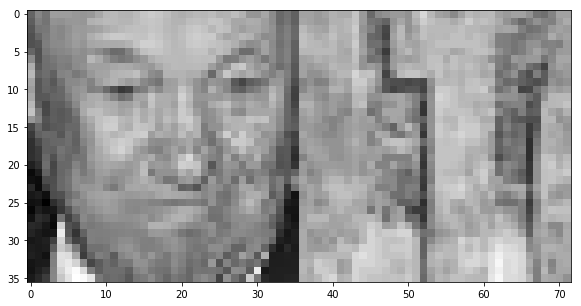

In [4]:
def show_example(idx):
    face = TRIAN_1_IMAGES[idx]
    noface = TRIAN_0_IMAGES[idx]
    pair = np.concatenate((face, noface), axis=1)
    plt.figure(figsize=(10,5))
    plt.imshow(pair, cmap='gray')
    plt.show()
    

show_example(1)

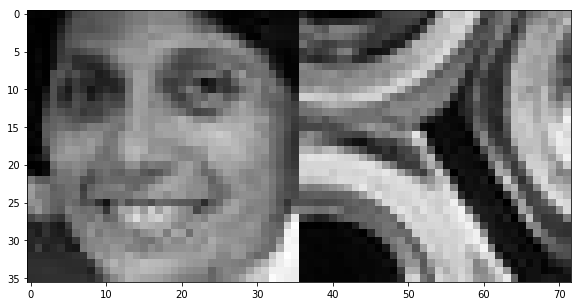

In [5]:
show_example(2)

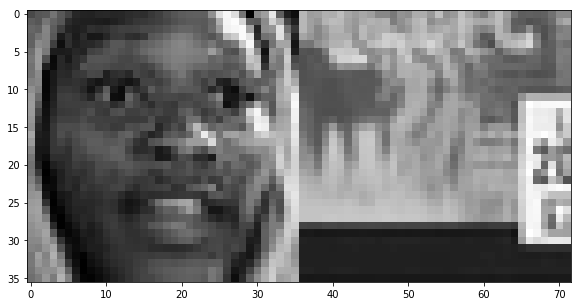

In [6]:
show_example(4)

## Prepar train set

10000
(10000, 36, 36, 1)
10000
10000
[1 0 1 1 1 0 0 1 1 1]
6000
(6000, 36, 36, 1)
0


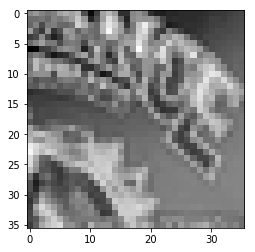

1


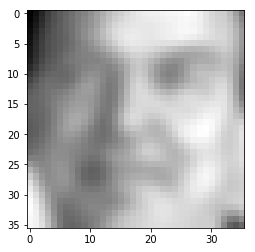

1


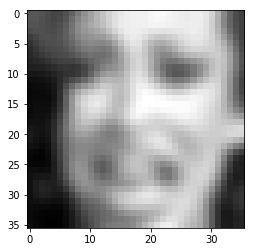

1


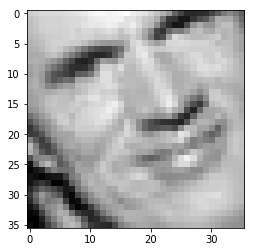

In [7]:
NB_TEST_BY_CLASS = 3000
def shuffle_and_get_new_train_set():
    random.shuffle(TRIAN_1_IMAGES)
    random.shuffle(TRIAN_0_IMAGES)
    test_images_1 = TRIAN_1_IMAGES[:NB_TEST_BY_CLASS]
    test_images_0 = TRIAN_0_IMAGES[:NB_TEST_BY_CLASS]
    train_1 = TRIAN_1_IMAGES[NB_TEST_BY_CLASS:]
    train_0 = TRIAN_0_IMAGES[NB_TEST_BY_CLASS:]
    return train_1, train_0, test_images_1, test_images_0

def prepar_train_images():
    train_1, train_0, test_images_1, test_images_0 = shuffle_and_get_new_train_set()
    train_images = np.array(list(train_1[:(20000+len(HARD_EXAMPLE_SET))]) +\
                            list(train_0[:20000]) + list(HARD_EXAMPLE_SET))
    train_images.resize((len(train_images), 36, 36, 1))
    train_and_label = list(zip(train_images, ([1]*(len(train_images)//2)) + ([0]*(len(train_images)//2))))
    random.shuffle(train_and_label)
    train_images = list(map(lambda x: x[0], train_and_label))
    train_labels = list(map(lambda x: x[1], train_and_label))
    test_imagies = list(test_images_1) + list(test_images_0)
    test_imagies = np.array(test_imagies)
    test_imagies.resize((NB_TEST_BY_CLASS*2, 36, 36, 1))
    return np.array(train_images), np.array(train_labels), test_imagies
    

    
    

train_images, train_labels, test_imagies = prepar_train_images()
print(len(train_images))
print(train_images.shape)
print(len(train_labels))
print(train_labels.size)
print(train_labels[:10])
print(len(test_imagies))
print(test_imagies.shape)

print(train_labels[1])
plt.imshow(train_images[1].reshape((36,36)), cmap='gray')
plt.show()
print(train_labels[2])
plt.imshow(train_images[2].reshape((36,36)), cmap='gray')
plt.show()
print(train_labels[3])
plt.imshow(train_images[3].reshape((36,36)), cmap='gray')
plt.show()
print(train_labels[4])
plt.imshow(train_images[4].reshape((36,36)), cmap='gray')
plt.show()

In [8]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def faceRecognition():
    
    model = Sequential()

    model.add(Conv2D(4, 5, strides=(1,1), border_mode='same',
                     input_shape=(36, 36, 1), data_format="channels_last", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(16, 3, strides=(1,1), border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(14, activation='relu'))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = faceRecognition()

/home/hlnaima/workspace/ConvNetFaceDetection/virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(4, 5, strides=(1, 1), input_shape=(36, 36, 1..., data_format="channels_last", activation="relu", padding="same")`
  # Remove the CWD from sys.path while we load stuff.
/home/hlnaima/workspace/ConvNetFaceDetection/virtualenv/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, 3, strides=(1, 1), activation="relu", padding="same")`
  del sys.path[0]


In [9]:
nb_epoch = 5
batch_size = 32

class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
def train_model():
    
    history = LossHistory()
    model.fit(train_images, train_labels, batch_size=batch_size, nb_epoch=nb_epoch,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[history, early_stopping])
    return history

history = train_model()

/home/hlnaima/workspace/ConvNetFaceDetection/virtualenv/lib/python3.6/site-packages/keras/models.py:939: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


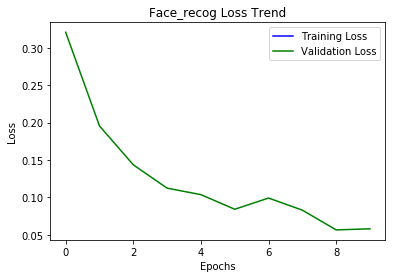

In [10]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Face_recog Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

## Multiple iteration training 

In [11]:
from time import sleep

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto') 
BATCH_SIZE = 32
NB_EPOCH = 10


def addjust_train_set_for_hard_example(predictions, threshold):
    hard_0_ex_list = []
    nb_easy_ex_added = 0
    nb_hard_ex_added = 0
    for i in range(NB_TEST_BY_CLASS):
        if predictions[NB_TEST_BY_CLASS+i] > threshold:
            hard_0_ex_list.append(list(np.array(test_imagies[NB_TEST_BY_CLASS+i]).reshape(36,36)))
            nb_hard_ex_added += 1 
        else:
            if nb_easy_ex_added < nb_hard_ex_added:
                hard_0_ex_list.append(list(np.array(test_imagies[NB_TEST_BY_CLASS+i]).reshape(36,36)))
                nb_easy_ex_added += 1
    add_hard_no_face_example(hard_0_ex_list)

def multiple_iteration_train_model(nb_iteration=10):
    threshold_step = (0.9-0.5)/nb_iteration
    model = None
    for i in range(nb_iteration):
        sleep(10)
        model = faceRecognition()
        train_images, train_labels, test_imagies = prepar_train_images()
        model.fit(train_images, train_labels, batch_size=BATCH_SIZE, nb_epoch=NB_EPOCH,
                  validation_split=0.25, verbose=0, shuffle=True, callbacks=[early_stopping])
        predictions = model.predict(test_imagies, verbose=0)
        print(len(list(filter(lambda x: x > (0.5+(i*threshold_step)), predictions[NB_TEST_BY_CLASS:]))))
        print(len(list(filter(lambda x: x < (0.5+(i*threshold_step)), predictions[:NB_TEST_BY_CLASS]))))
        addjust_train_set_for_hard_example(predictions, (0.5+(i*threshold_step)))
    return model
        
        
#model = multiple_iteration_train_model(nb_iteration=5)

## Test model

In [ ]:
predictions = model.predict(test_imagies, verbose=0)

[30, 48, 49, 52, 99, 115, 161, 209, 258, 334, 370, 404, 522, 582, 1362]
[63, 28, 18, 17, 9, 7, 6, 5, 2, 1, 1, 1, 1, 1, 0]
nb error optimum : 67 for tolereance of : [0.5]


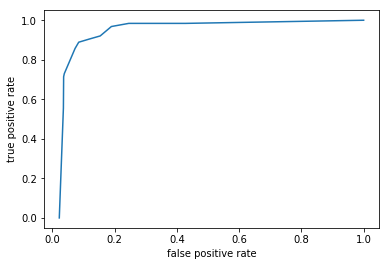

In [12]:
false_pos = []
false_neg = []
nb_error = []
for tolerance in [0.9, 0.6, 0.5, 0.4, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001, 0.0005, 0.0002, 0.0001, 0]:
    false_neg.append(len(list(filter(lambda x: x[0] == x[1], list(zip(([0]*(len(test_imagies)//2)), list(map(lambda x: int(x+tolerance), predictions[:(len(test_imagies)//2)]))))))))
    false_pos.append(len(list(filter(lambda x: x[0] == x[1], list(zip(([1]*(len(test_imagies)//2)), list(map(lambda x: int(x+tolerance), predictions[(len(test_imagies)//2)+1:]))))))))
    nb_error.append((len(list(filter(lambda x: x[0] == x[1], list(zip(([0]*(len(test_imagies)//2)) +
                                                                        [1]*(len(test_imagies)//2),
                                       list(map(lambda x: int(x+tolerance), predictions))))))), tolerance))
print(false_pos)
print(false_neg)
print("nb error optimum : " + str(min(list(map(lambda x: x[0], nb_error)))) + " for tolereance of : " +
     str(list(map(lambda x: x[1], list(filter(lambda x: x[0] == min(list(map(lambda x: x[0], nb_error))), nb_error))))))

false_pos_rate = list(map(lambda x: x/max(false_pos), false_pos))
true_pos_rate = list(map(lambda x: (1-(x/max(false_neg))), false_neg))

plt.plot(false_pos_rate, true_pos_rate)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.show()


## Save model

In [13]:
model.save('my_model.h5')

# returns a compiled model
# identical to the previous one

ImportError: `save_model` requires h5py.

In [ ]:

del model  # deletes the existing model

model = load_model('my_model.h5')
predictions = model.predict(test_imagies, verbose=0)

false_pos = []
false_neg = []
nb_error = []
for tolerance in [0.9, 0.6, 0.5, 0.4, 0.1, 0.05, 0.02, 0.01, 0.005, 0.002, 0.001, 0.0005, 0.0002, 0.0001, 0]:
    false_neg.append(len(list(filter(lambda x: x[0] == x[1], list(zip(([0]*(len(test_imagies)//2)), list(map(lambda x: int(x+tolerance), predictions[:(len(test_imagies)//2)]))))))))
    false_pos.append(len(list(filter(lambda x: x[0] == x[1], list(zip(([1]*(len(test_imagies)//2)), list(map(lambda x: int(x+tolerance), predictions[(len(test_imagies)//2)+1:]))))))))
    nb_error.append((len(list(filter(lambda x: x[0] == x[1], list(zip(([0]*(len(test_imagies)//2)) +
                                                                        [1]*(len(test_imagies)//2),
                                       list(map(lambda x: int(x+tolerance), predictions))))))), tolerance))
print(false_pos)
print(false_neg)